In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
from sklearn import neighbors

h = 0.005

n_neighbors = 15  # Choose an odd number here
n_classes = 2

n_datapts = 5000  # Number of datapoints in training dataset
length = .25
angle = np.pi / 4

def gen_cb(N, a, alpha): 
    """
    N: number of points on the checkerboard
    a: width of the checker board (0<a<1)
    alpha: rotation of the checkerboard in radians 
    """
    d = np.random.rand(N, 2).T
    d_transformed = np.array([d[0]*np.cos(alpha)-d[1]*np.sin(alpha), 
                              d[0]*np.sin(alpha)+d[1]*np.cos(alpha)]).T
    s = np.ceil(d_transformed[:,0]/a)+np.floor(d_transformed[:,1]/a)
    lab = 2 - (s%2)
    data = d.T
    return data, lab

X, y = gen_cb(n_datapts, length, angle)  # Training dataset

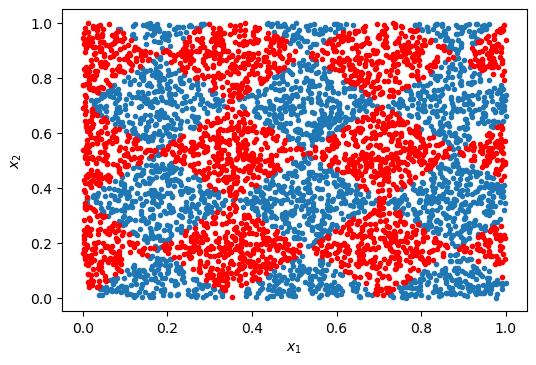

In [2]:
plt.figure(dpi=100)
plt.plot(X[np.where(y==1)[0], 0], X[np.where(y==1)[0], 1], '.')
plt.plot(X[np.where(y==2)[0], 0], X[np.where(y==2)[0], 1], '.', c='r')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

In [3]:
unique, counts = np.unique(y, return_counts=True)
priors = counts / n_datapts  # MLE priors

dx = 0.0001
xx1, xx2 = np.meshgrid(np.arange(0 - dx, 1 + dx, h), 
                       np.arange(0 - dx, 1 + dx, h))

XX = np.c_[xx1.ravel(), xx2.ravel()]
N = len(XX)

dist = distance.cdist(XX, X, 'euclidean')
idx_sorted_by_dist = np.argsort(dist, axis=1)
k_nearest_idx = idx_sorted_by_dist[:, 0: n_neighbors]
nearest_classes = np.take(y, k_nearest_idx)

k = np.zeros((N, n_classes))
for i, j in enumerate(nearest_classes):
    k_1 = np.count_nonzero(j == unique[0])
    k_2 = np.count_nonzero(j == unique[1])
    k[i] = [k_1, k_2]
    
volumes = np.zeros(N)
for i, x in enumerate(XX):
    volumes[i] = np.pi * (np.linalg.norm(XX[k_nearest_idx[i][-1]] - x) ** 2)
volumes[np.where(volumes == 0)] = np.finfo(float).eps
    
p_x_given_1 = k[:, 0] / (counts[0] * volumes)
p_x_given_2 = k[:, 1] / (counts[1] * volumes)  # Density estimators

numerator_1 = p_x_given_1 * priors[0]
numerator_2 = p_x_given_2 * priors[1]

denominator = numerator_1 + numerator_2  # p(x)

posterior_1 = numerator_1 / denominator
posterior_2 = numerator_2 / denominator

probs = np.vstack([posterior_1, posterior_2]).T
y_predict = np.argmax(probs, axis=1) + 1

zz = y_predict.reshape(xx1.shape)
z_min, z_max = -np.abs(zz).max(), np.abs(zz).max()

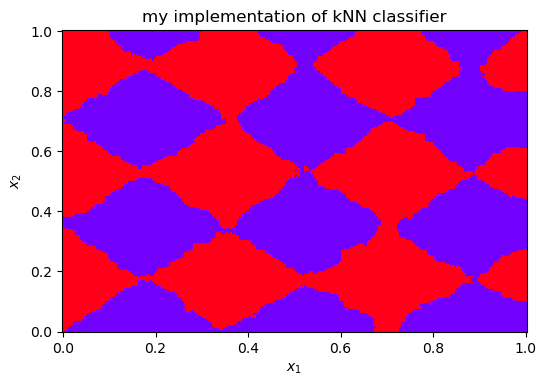

In [4]:
plt.figure(dpi=100)
c = plt.pcolor(xx1, xx2, zz, cmap='hsv', vmin=z_min, vmax=z_max, shading='auto')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('my implementation of kNN classifier')
plt.show()

In [5]:
clf = neighbors.KNeighborsClassifier(n_neighbors, weights='uniform')
clf.fit(X, y)
zzz = clf.predict(XX)
zzz = zzz.reshape(xx1.shape)

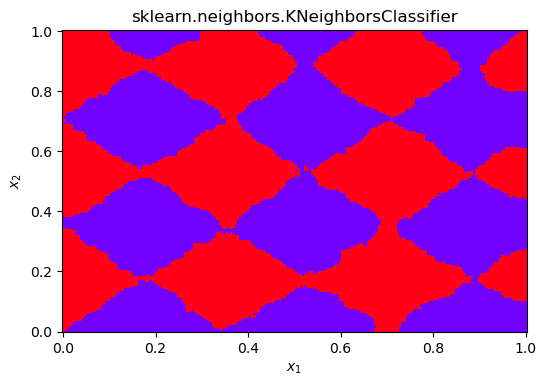

In [6]:
plt.figure(dpi=100)
c = plt.pcolor(xx1, xx2, zzz, cmap='hsv', vmin=z_min, vmax=z_max, shading='auto')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('sklearn.neighbors.KNeighborsClassifier')
plt.show()